In [10]:
import numpy as np
from scipy import special as sp
from common.baseclasses import ArrayWithAxes as AWA
import matplotlib.pyplot as plt

In [11]:
class Translator:
    """
        Allows for the translation of the center point of functions within an xy mesh space.
        
        Works by generating a bessel function on
        a much larger xy mesh and then translating/truncating to the
        original mesh.  Nothing fancy, but good for performance.
    """
    
    """
        TODO: Something is going on that flips the x and y coordinates when plotting or translating.
        
        Doesn't make much sense...
    """

    def __init__(self,q=20, \
                 xs=np.linspace(-1,1,101), \
                 ys=np.linspace(-1,1,101),
                 f = lambda x,y: sp.jv(0,np.sqrt(x**2+y**2))):

        self.f = f

        #Bookkeeping of the coordinate mesh
        self.xs,self.ys=xs,ys
        self.shape=(len(xs),len(ys))
        self.midx=self.xs[self.shape[0]//2]
        self.midy=self.ys[self.shape[1]//2]
        self.dx=np.max(self.xs)-np.min(self.xs)
        self.dy=np.max(self.ys)-np.min(self.ys)

        #Make a mesh grid twice bigger in each direction
        bigshape=[2*N-1 for N in self.shape]
        xs2grid,ys2grid=np.ogrid[-self.dx:+self.dx:bigshape[0]*1j,
                                 -self.dy:+self.dy:bigshape[1]*1j]

        self.bigF = self.f(xs2grid,ys2grid)

    def __call__(self,x0,y0):
        shift_by_dx=x0-self.midx
        shift_by_dy=y0-self.midy
        shift_by_nx=int(self.shape[0]*shift_by_dx/self.dx)
        shift_by_ny=int(self.shape[1]*shift_by_dy/self.dy)
        newJ=np.roll(np.roll(self.bigF,shift_by_nx,axis=0),\
                     shift_by_ny,axis=1)
        output = newJ[self.shape[0]//2:(3*self.shape[0])//2,\
                     self.shape[1]//2:(3*self.shape[1])//2]
        return AWA(output,axes=[self.xs,self.ys])


In [12]:
class SampleResponse:
    """
        Generator of sample response based on an input collection of
        eigenpairs (dictionary of eigenvalues + eigenfunctions).
        
        Can output a whole set of sample response functions from
        an input set of excitation functions.
    """

    def __init__(self,eigpairs,E,N=100,debug=True):
        # Setting the easy stuff
        eigvals = list(eigpairs.keys())
        eigfuncs = list(eigpairs.values())
        self.debug = debug
        self.xs,self.ys = eigfuncs[0].axes
        self.eigfuncs = AWA(eigfuncs,\
                          axes=[eigvals,self.xs,self.ys]).sort_by_axes()
        self.eigvals = self.eigfuncs.axes[0]
        self.phishape = self.eigfuncs[0].shape
        self.E = E
        self.N = N

        # Setting the various physical quantities
        self._SetUseEigenvalues(E)
        self._SetEnergy()
        self._SetSigma(10,10)
        self._SetCoulombKernel()
        self._SetScatteringMatrix()

    def _SetEnergy(self):
        """
            TODO: check energy units and sqrt eigenvals
        """
        if self.debug: print('Setting Energy')
        self._SetUseEigenvalues()
        self.Phis=np.matrix([eigfunc.ravel() for eigfunc in self.use_eigfuncs])

        self.use_eigvals=self.eigvals[ind1:ind2]
        self.Q = np.diag(self.use_eigvals)
        
    def _SetUseEigenvalues(self, E):
        if self.debug: print('Setting Use Eigenvalues')
        index=np.argmin(np.abs(np.sqrt(self.eigvals)-E)) #@ASM2019.12.22 - This is to treat `E` not as the squared eigenvalue, but in units of the eigenvalue (`q_omega)
        ind1=np.max([index-self.N//2,0])
        ind2=ind1+self.N
        if ind2>len(self.eigfuncs):
            ind2 = len(self.eigfuncs)
            ind1 = ind2-self.N
        self.use_eigfuncs=self.eigfuncs[ind1:ind2]

    def _SetSigma(self,L,lamb):
        if self.debug: print('Setting Sigma')
        
        self.sigma = PM.S()
        self.sigma.set_sigma_values(lamb, L)
        sigma_tilde = self.sigma.get_sigma_values()[0]+1j*self.sigma.get_sigma_values()[1]
        self.alpha = -1j*sigma_tilde/np.abs(sigma_tilde)
        
        """
            TODO: Do we need to change this? As of 2019.12.21, this was a placeholder
        """
        self.alpha = 1 #@ASM2019.12.21 just for nwo we put the 'complexity' into input `E`, until we get serious about recasting it to `q_omega`

    def _SetCoulombKernel(self):
        """
            TODO: I hacked this together in some crazy way to force multiprocessing.Pool to work...
                    Needs to be understood and fixed
        """
        if debug: print('Setting Kernel')
        self.V_nm = np.zeros([len(self.use_eigvals), len(self.use_eigvals)])
        eigfuncs = self.use_eigfuncs
        kern_func = lambda x,y: 1/np.sqrt(x**2+y**2+1e-4)
        global myQC
        size=(self.xs.max()-self.xs.min(),self.ys.max()-self.ys.min())
        myQC=numrec.QuickConvolver(size=size,kernel_function=kern_func,\
                                   shape=eigfuncs[0].shape,pad_by=.5,pad_with=0)
        p = mp.Pool(8)
        self.V_nm = np.array(p.starmap(Calc,product(eigfuncs,eigfuncs))).reshape((self.N,self.N))

    def _SetScatteringMatrix(self):
        if debug: print('Setting Scattering Matrix')
        self.D = self.E*np.linalg.inv(self.E*np.identity(self.Q.shape[0]) - self.alpha*self.Q.dot(self.V_nm))

    def GetRAlphaBeta(self,tip_eigenbasis):
        t1=time.time()
        Psi=np.matrix([eigfunc.ravel() for eigfunc in tip_eigenbasis]) #Only have to unravel sample eigenfunctions once (twice speed-up)
        U=Psi*self.Phis.T
        U_inv = np.linalg.pinv(U) #@ASM2019.12.21 good to use inverse, since tip-basis may not be orthogonal
        result=np.dot(U,np.dot(self.D,U_inv))
        return result

    def __call__(self,excitations,U,tip_eigenbasis):
        if np.array(excitations).ndim==2: excitations=[excitations]
        Exc=np.array([exc.ravel() for exc in excitations])
        tip_eb=np.matrix([eigfunc.ravel() for eigfunc in tip_eigenbasis])
        projected_result=np.dot(tip_eb.T,
                            np.dot(U,\
                                np.dot(self.D,\
                                    np.dot(self.Phis,Exc.T))))
        #plt.figure();plt.imshow(np.abs(result.reshape(101,101)));plt.show()

        #These are all the matrices that get multiplied, take a look that shapes work...
        #print([item.shape for item in [self.Phis.T,self.D,self.Phis,Exc.T]])
        #result is in form of column vectors
        #turn into row vectors then reshape
        result=np.dot(self.Phis.T,\
                       np.dot(self.D,\
                             np.dot(self.Phis,Exc.T)))
        result=np.array(result).T.reshape((len(excitations),)+self.phishape)
        projected_result=np.array(projected_result).T.reshape((len(excitations),)+self.phishape)
        return AWA(result,axes=[None,self.xs,self.ys]).squeeze(), AWA(projected_result,axes=[None,self.xs,self.ys]).squeeze()

In [16]:
def tester():
    def mybessel(v,A,Q,x,y):
        r = np.sqrt(x**2+y**2)
        theta = np.arctan2(x,y)
        return A*sp.jv(v,Q*r)

    def planewave(qx,qy,x,y):
        return np.sin(qx*x+qy*y)

    def spherical_harmonic(m,n,x,y):
        theta = np.arctan2(x,y)
        phi = np.pi/4
        return sp.sph_harm(m,n,phi,theta)

    N=5
    q=20

    for n in range(0,N):
        q_prefactor = (2*q*(n+1)/(N+1))**2
        exp_prefactor = np.exp(-2*(n+1)/(N+1))
        A = q_prefactor*exp_prefactor
        Q = (2*q*(n+1)/(N+1))

        #func = lambda x,y: np.real(spherical_harmonic(0,n,x,y))
        func = lambda x,y: mybessel(0,A,Q,x,y)
        #func = lambda x,y: planewave(0,2,x,y)

        gen = Translator(xs=np.linspace(-1,1,101), ys=np.linspace(-1,1,101),f=func)
        plt.figure()
        plt.imshow(gen(0,0.5), extent = [-1,1,-1,1], origin='bottom')
        plt.show()

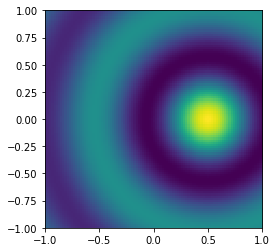

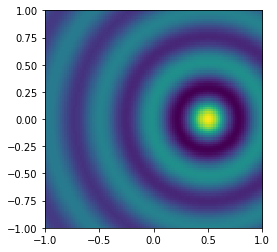

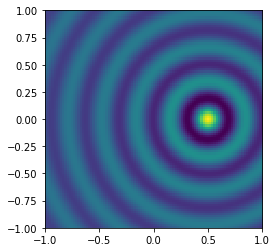

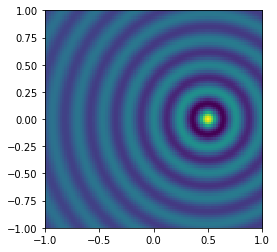

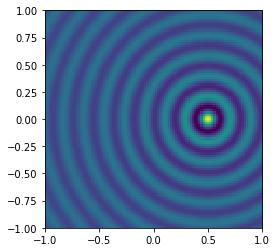

In [17]:
tester()